In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import os
import sys
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import time
from collections import Counter
tqdm.pandas(tqdm_notebook)
import lightgbm as lgb
import gc
%matplotlib inline
import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
pd.set_option('display.float_format', '{:.5f}'.format)
np.random.seed(51)

In [2]:
train = dd.read_csv('../input/train_last.csv')
train = train.compute()
train = train.reset_index(drop=True)
test = dd.read_csv('../input/test_last.csv')
test = test.compute()
test = test.reset_index(drop=True)

In [5]:
useful_columns = ['card_id', 'first_active_month']+  ['feature_1', 'feature_3', 'active_year', 'h_af_std', 'h_af_mean', 'h_most_common_category_1', 'h_second_most_common_category_1', 'h_num_second_most_common_category_1', 'h_ins_sum', 'h_ins_mean', 'h_how_many_merchant_category_id_visited', 'h_num_most_common_merchant_category_id', 'h_how_many_merchant_id_visited', 'h_num_most_common_merchant_id', 'h_num_second_most_common_merchant_id', 'h_binned_purchase_amount_sum', 'h_binned_purchase_amount_mean', 'h_month_lag_sum', 'h_month_lag_min', 'h_month_lag_max', 'h_month_lag_std', 'h_month_lag_mean', 'h_month_lag_median', 'h_purchase_amount_sum', 'h_purchase_amount_median', 'h_max_25_percentile_diff', 'h_max_min_diff', 'h_75_percentile_min_diff', 'h_50_percentile_min_diff', 'h_how_many_unique_subsector_id', 'h_most_common_subsector_id', 'h_num_most_common_subsector_id', 'n_af_sum', 'n_num_most_visited_city', 'n_most_common_category_1', 'n_ins_sum', 'n_ins_min', 'n_ins_max', 'n_ins_median', 'n_num_most_common_category_3', 'n_how_many_merchant_category_id_visited', 'n_how_many_merchant_id_visited', 'n_binned_purchase_amount_sum', 'n_binned_purchase_amount_max', 'n_month_lag_min', 'n_month_lag_max', 'n_month_lag_std', 'n_month_lag_mean', 'n_month_lag_median', 'n_purchase_amount_sum', 'n_purchase_amount_max', 'n_purchase_amount_std', 'n_purchase_amount_mean', 'n_max_25_percentile_diff', 'n_max_min_diff', 'elapsed_time', 'h_transactions_count', 'h_category_1_sum', 'h_month_diff_mean', 'a_category_1_sum', 'a_category_1_mean', 'a_category_3_B_mean', 'a_purchase_month_max', 'a_purchase_month_min', 'a_purchase_month_std', 'a_month_diff_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_3_A_mean', 'new_category_3_B_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_month_diff_mean', 'month_lag_mean', 'month_lag_std', 'purchase_amount_count_mean', 'purchase_amount_mean_mean', 'purchase_amount_max_mean', 'purchase_amount_max_std', 'purchase_amount_std_mean', 'installments_count_mean', 'installments_sum_mean', 'installments_mean_std', 'category_1_purchase_amount_mean', 'category_1_purchase_amount_max', 'installments_purchase_amount_max', 'city_id_purchase_amount_max', 'category_1_installments_std']

In [6]:
train = train[useful_columns + ['target']]
test = test[useful_columns]

In [7]:
print(train.shape,test.shape)

(201917, 92) (123623, 91)


In [8]:
temp = train.dtypes.reset_index(drop=False)
temp.columns = ['column','type']
for i in [x for x in list(temp[temp['type'] == 'object']['column']) if x not in ['card_id', 'first_active_month']]:
    le = preprocessing.LabelEncoder()
    le.fit(list(train[i].values) + list(test[i].values ) )
    train[i] = le.transform( list(train[i].values) )
    test[i] = le.transform( list(test[i].values) )
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

In [9]:
target = train['target']
del train['target']

In [10]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
#categorical_feats = ['feature_2', 'feature_3']

In [11]:
train.head()

,card_id,first_active_month,feature_1,feature_3,active_year,h_af_std,h_af_mean,h_most_common_category_1,h_second_most_common_category_1,h_num_second_most_common_category_1,h_ins_sum,h_ins_mean,h_how_many_merchant_category_id_visited,h_num_most_common_merchant_category_id,h_how_many_merchant_id_visited,h_num_most_common_merchant_id,h_num_second_most_common_merchant_id,h_binned_purchase_amount_sum,h_binned_purchase_amount_mean,h_month_lag_sum,h_month_lag_min,h_month_lag_max,h_month_lag_std,h_month_lag_mean,h_month_lag_median,h_purchase_amount_sum,h_purchase_amount_median,h_max_25_percentile_diff,h_max_min_diff,h_75_percentile_min_diff,h_50_percentile_min_diff,h_how_many_unique_subsector_id,h_most_common_subsector_id,h_num_most_common_subsector_id,n_af_sum,n_num_most_visited_city,n_most_common_category_1,n_ins_sum,n_ins_min,n_ins_max,n_ins_median,n_num_most_common_category_3,n_how_many_merchant_category_id_visited,n_how_many_merchant_id_visited,n_binned_purchase_amount_sum,n_binned_purchase_amount_max,n_month_lag_min,n_month_lag_max,n_month_lag_std,n_month_lag_mean,n_month_lag_median,n_purchase_amount_sum,n_purchase_amount_max,n_purchase_amount_std,n_purchase_amount_mean,n_max_25_percentile_diff,n_max_min_diff,elapsed_time,h_transactions_count,h_category_1_sum,h_month_diff_mean,a_category_1_sum,a_category_1_mean,a_category_3_B_mean,a_purchase_month_max,a_purchase_month_min,a_purchase_month_std,a_month_diff_mean,new_category_1_sum,new_category_1_mean,new_category_3_A_mean,new_category_3_B_mean,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_mean_mean,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,installments_count_mean,installments_sum_mean,installments_mean_std,category_1_purchase_amount_mean,category_1_purchase_amount_max,installments_purchase_amount_max,city_id_purchase_amount_max,category_1_installments_std
0,C_ID_92a2005557,2017-06-01,5,1,2017,0.21837,0.95000,0,2,nan,4,0.01538,41,61,94,32,23.00000,1421,5.46538,-1017,-8,0,2.39769,-3.91154,-4.00000,-165.96874,-0.69804,198,242,176,111,21,34,97,23.00000,19.00000,0,0.00000,0.00000,0.00000,0.00000,23.00000,14.00000,23.00000,142.00000,8.00000,1.00000,2.00000,0.51075,1.47826,1.00000,-13.24420,-0.29611,0.13581,-0.57583,44.00000,54.00000,245,13.00000,0.00000,12.00000,0,0.00000,0.00000,12,1,3.52857,12.00000,0.00000,0.00000,1.00000,0.00000,3.47826,4.00000,3.00000,11.95652,-4.00000,2.73861,27.44444,-0.65048,-0.15882,0.91602,0.10958,27.44444,0.00000,0.00000,-0.57583,-0.57583,-0.57583,-0.29611,nan
1,C_ID_3d0044924f,2017-01-01,4,0,2017,0.17472,0.96857,0,1,31.00000,543,1.55143,57,54,142,27,26.00000,1849,5.28286,-1761,-12,0,3.80493,-5.03143,-5.00000,-210.00634,-0.70859,248,390,333,209,24,34,74,6.00000,6.00000,0,6.00000,1.00000,1.00000,1.00000,6.00000,5.00000,6.00000,21.00000,5.00000,1.00000,2.00000,0.54772,1.50000,1.50000,-4.35573,-0.70186,0.01433,-0.72596,52.00000,56.00000,396,11.00000,2.00000,13.09091,29,0.08555,0.80236,12,1,3.85918,13.04130,0.00000,0.00000,0.00000,1.00000,2.50000,3.00000,2.00000,13.00000,-6.00000,3.89444,26.07692,-0.59336,0.51066,1.32703,0.28211,26.07692,38.53846,0.45385,-0.72596,-0.72596,-0.72596,-0.72596,nan
2,C_ID_d639edf6cd,2016-08-01,2,0,2016,0.21308,0.95349,0,2,nan,0,0.00000,8,32,13,28,3.00000,232,5.39535,-370,-13,0,3.84299,-8.60465,-10.00000,-29.16739,-0.69887,368,412,234,101,7,33,32,1.00000,1.00000,0,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,5.00000,5.00000,2.00000,2.00000,nan,2.00000,2.00000,-0.70033,-0.70033,nan,-0.70033,0.00000,0.00000,549,2.00000,0.00000,12.00000,0,0.00000,0.00000,12,1,3.32984,12.02439,0.00000,0.00000,1.00000,0.00000,4.00000,4.00000,4.00000,12.00000,-6.66667,4.39697,3.41667,-0.66932,-0.62109,0.15178,0.06594,3.41667,0.00000,0.00000,-0.70033,-0.70033,-0.70033,-0.70033,nan
3,C_ID_186d6a6901,2017-09-01,4,0,2017,0.00000,1.00000,0,1,12.00000,84,1.09091,25,13,50,9,7.00000,389,5.05195,-218,-5,0,1.802

In [12]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 51,
         "verbosity": -1}

In [13]:
folds = KFold(n_splits=5, shuffle=True, random_state=51)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features].values,
                           label=target.iloc[trn_idx].values,
                           #categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features].values,
                           label=target.iloc[val_idx].values,
                           #categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.63426	valid_1's rmse: 3.78886
[200]	training's rmse: 3.5639	valid_1's rmse: 3.74889
[300]	training's rmse: 3.52417	valid_1's rmse: 3.7354
[400]	training's rmse: 3.4963	valid_1's rmse: 3.73053
[500]	training's rmse: 3.47375	valid_1's rmse: 3.72722
[600]	training's rmse: 3.45391	valid_1's rmse: 3.72609
[700]	training's rmse: 3.43488	valid_1's rmse: 3.72505
[800]	training's rmse: 3.41791	valid_1's rmse: 3.7245
[900]	training's rmse: 3.39982	valid_1's rmse: 3.72418
[1000]	training's rmse: 3.38285	valid_1's rmse: 3.72452
Early stopping, best iteration is:
[884]	training's rmse: 3.40291	valid_1's rmse: 3.72388
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.6717	valid_1's rmse: 3.63308
[200]	training's rmse: 3.60072	valid_1's rmse: 3.59835
[300]	training's rmse: 3.56175	valid_1's rmse: 3.58902
[400]	training's rmse: 3.53526	valid_1's rmse: 3.58537


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


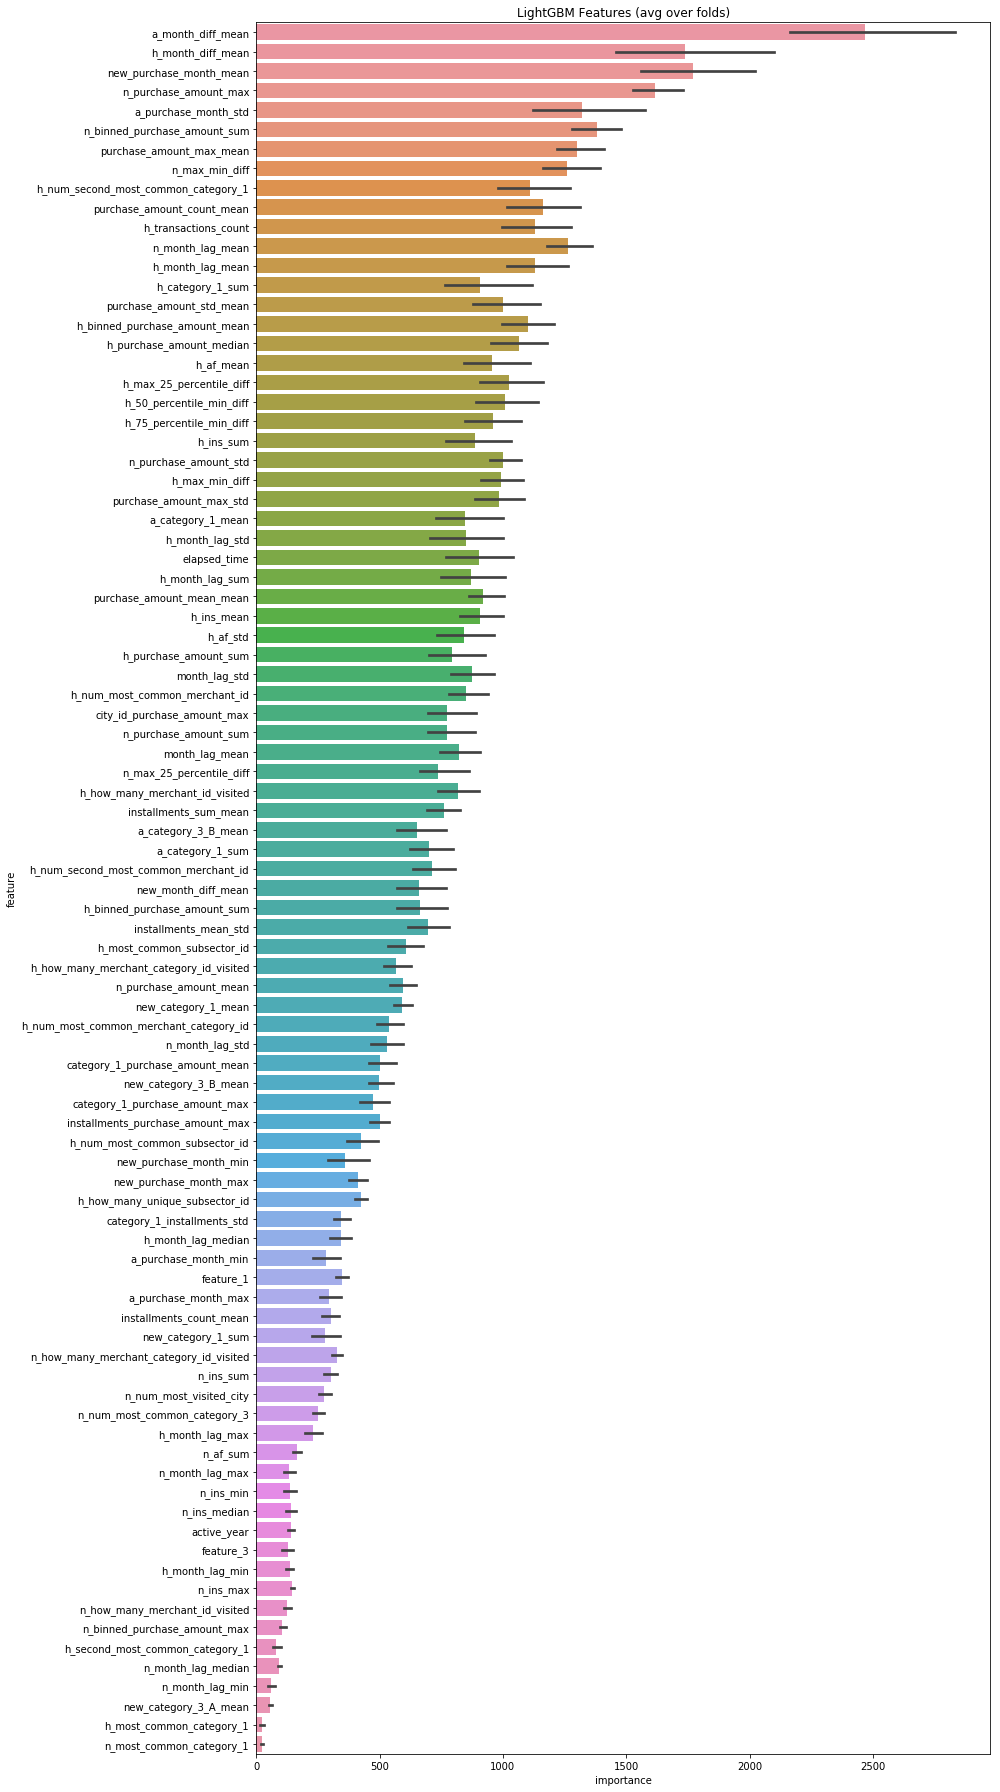

In [14]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [15]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)